## NBA - ML Clustering(Segmentacion) Clasificación No Supervisada de Jugadores (SCOUTING) - Utilizando estadísticas por 100 Posesiones.

- Para aplicar este desarrollo primero hay que lanzar la ETL en forma de script python  **C:\Users\RubenGA\WorkSpaces_rga01\Python\Scripts\NBA_API_TeamsPlayers_DataStatic_Practicas_00.py** que recupera la info necesaria para dar soporte al aplicativo web convirtiendo los datos en ficheros estáticos CSV y de los cuales se utilizará "df_players_stats_per100poss.csv".

In [1]:
# Importando librerias
import pandas as pd
import numpy as np
import time
import os
from matplotlib import pyplot as plt # import matplotlib.pyplot as plt
import seaborn as sb
import plotly.express as px
import pickle

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.cluster import KMeans, AgglomerativeClustering


#from sklearn import model_selection
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score


In [2]:
# Parámetros generales
pd.set_option('display.max_columns', None)

print(os.getcwd())

C:\Users\RubenGA\WorkSpaces_rga01\Python\Notebooks\Practicas_NBA


In [3]:
# DATA
path = "C:/Users/RubenGA/WorkSpaces_rga01/Python/Data/"
file = "df_players_stats_per100poss.csv"
df_00 = pd.read_csv(path+file, index_col=0)
df_00.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 1145 entries, 0 to 1144
Data columns (total 69 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   PLAYER_ID              1145 non-null   int64  
 1   PLAYER_NAME            1145 non-null   object 
 2   NICKNAME               1145 non-null   object 
 3   TEAM_ID                1145 non-null   int64  
 4   TEAM_ABBREVIATION      1145 non-null   object 
 5   AGE                    1145 non-null   float64
 6   GP                     1145 non-null   int64  
 7   W                      1145 non-null   int64  
 8   L                      1145 non-null   int64  
 9   W_PCT                  1145 non-null   float64
 10  MIN                    1145 non-null   float64
 11  FGM                    1145 non-null   float64
 12  FGA                    1145 non-null   float64
 13  FG_PCT                 1145 non-null   float64
 14  FG3M                   1145 non-null   float64
 15  FG3A

### Tratamiento y Preprocesado de los datos..

In [4]:
df_00 = df_00.iloc[:, np.r_[:32,68]]
df_00.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1145 entries, 0 to 1144
Data columns (total 33 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   PLAYER_ID          1145 non-null   int64  
 1   PLAYER_NAME        1145 non-null   object 
 2   NICKNAME           1145 non-null   object 
 3   TEAM_ID            1145 non-null   int64  
 4   TEAM_ABBREVIATION  1145 non-null   object 
 5   AGE                1145 non-null   float64
 6   GP                 1145 non-null   int64  
 7   W                  1145 non-null   int64  
 8   L                  1145 non-null   int64  
 9   W_PCT              1145 non-null   float64
 10  MIN                1145 non-null   float64
 11  FGM                1145 non-null   float64
 12  FGA                1145 non-null   float64
 13  FG_PCT             1145 non-null   float64
 14  FG3M               1145 non-null   float64
 15  FG3A               1145 non-null   float64
 16  FG3_PCT            1145 

In [5]:
print(len(df_00))
df_00.head()

1145


,PLAYER_ID,PLAYER_NAME,NICKNAME,TEAM_ID,TEAM_ABBREVIATION,AGE,GP,W,L,W_PCT,MIN,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,FT_PCT,OREB,DREB,REB,AST,TOV,STL,BLK,BLKA,PF,PFD,PTS,PLUS_MINUS,SEASON
0,203932,Aaron Gordon,Aaron,1610612743,DEN,26.0,75,46,29,0.613,48.4,8.8,17.0,0.520,1.8,5.3,0.335,3.5,4.7,0.743,2.5,6.4,8.9,3.8,2.7,0.9,0.9,1.1,3.0,4.1,22.9,6.5,2021-22
1,1630565,Aaron Henry,Aaron,1610612755,PHI,22.0,6,6,0,1.000,44.7,2.6,13.2,0.200,0.0,2.6,0.000,0.0,0.0,0.000,0.0,2.6,2.6,0.0,5.3,0.0,5.3,5.3,5.3,0.0,5.3,-52.6,2021-22
2,1628988,Aaron Holiday,Aaron,1610612756,PHX,25.0,63,34,29,0.540,48.3,7.1,16.0,0.447,1.8,4.9,0.379,2.8,3.2,0.868,1.1,4.6,5.8,7.2,3.2,2.0,0.4,0.9,4.4,3.5,18.9,-1.8,2021-22
3,1630174,Aaron Nesmith,Aaron,1610612738,BOS,22.0,52,32,20,0.615,48.0,6.0,15.2,0.396,2.6,9.6,0.270,1.8,2.2,0.808,1.3,6.2,7.4,1.8,2.6,1.7,0.4,0.2,5.9,2.3,16.4,1.8,2021-22
4,1630598,Aaron Wiggins,Aaron,1610612760,OKC,23.0,50,13,37,0.260,47.5,6.1,13.2,0.463,1.6,5.4,0.304,2.4,3.3,0.729,2.0,5.0,7.0,2.7,2.1,1.2,0.4,0.8,3.7,2.5,16.3,-9.2,2021-22


In [6]:
# Filtramos para trabajar con los jugadores de la temporada 2021-22 y que hayan jugado 10 o más partidos..
df_00.query("GP >= 10 & SEASON == '2021-22'", inplace=True)
print(len(df_00))


500


### Con los datos filtrados se realiza un pequeño analisis (EDA)

<AxesSubplot:ylabel='Density'>

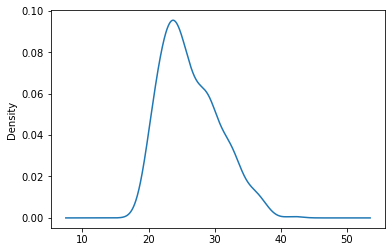

In [7]:
df_00.AGE.plot.kde()

In [8]:
df_00.iloc[:, 11:32]

,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,FT_PCT,OREB,DREB,REB,AST,TOV,STL,BLK,BLKA,PF,PFD,PTS,PLUS_MINUS
0,8.8,17.0,0.520,1.8,5.3,0.335,3.5,4.7,0.743,2.5,6.4,8.9,3.8,2.7,0.9,0.9,1.1,3.0,4.1,22.9,6.5
2,7.1,16.0,0.447,1.8,4.9,0.379,2.8,3.2,0.868,1.1,4.6,5.8,7.2,3.2,2.0,0.4,0.9,4.4,3.5,18.9,-1.8
3,6.0,15.2,0.396,2.6,9.6,0.270,1.8,2.2,0.808,1.3,6.2,7.4,1.8,2.6,1.7,0.4,0.2,5.9,2.3,16.4,1.8
4,6.1,13.2,0.463,1.6,5.4,0.304,2.4,3.3,0.729,2.0,5.0,7.0,2.7,2.1,1.2,0.4,0.8,3.7,2.5,16.3,-9.2
5,3.7,10.7,0.343,1.2,4.3,0.286,1.8,3.1,0.600,1.2,7.0,8.3,2.1,3.4,2.4,1.2,0.6,6.1,4.3,10.4,-0.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
598,3.2,10.3,0.313,1.9,5.8,0.333,0.0,1.3,0.000,3.2,4.5,7.7,0.6,0.6,0.6,2.6,0.6,3.8,1.9,8.3,-19.2
599,7.0,14.2,0.490,1.3,3.8,0.341,4.8,6.0,0.800,4.2,9.8,14.0,5.6,4.1,1.2,2.1,1.5,6.1,5.1,20.0,3.5
600,11.7,24.6,0.476,3.8,9.8,0.389,6.6,7.8,0.853,0.5,5.9,6.4,6.3,3.5,0.8,0.5,1.3,2.5,5.5,33.9,-0.5
602,6.7,12.9,0.516,2.6,5.5,0.463,2.8,4.5,0.631,3.9,6.3,10.2,1.2,1.6,1.1,0.9,1.3,5.5,3.6,18.7,-3.1


In [9]:
normalize(df_00.iloc[:, 11:32])

array([[ 0.25655926,  0.49562584,  0.01516032, ...,  0.11953329,
         0.66763716,  0.189504  ],
       [ 0.24099569,  0.54308888,  0.01517255, ...,  0.11880069,
         0.64152374, -0.0610975 ],
       [ 0.21277096,  0.53901977,  0.01404288, ...,  0.0815622 ,
         0.58157397,  0.06383129],
       ...,
       [ 0.2453237 ,  0.5158088 ,  0.00998069, ...,  0.11532311,
         0.71080969, -0.01048392],
       [ 0.23029103,  0.44339616,  0.01773585, ...,  0.12373846,
         0.64275258, -0.10655257],
       [ 0.24614315,  0.54449849,  0.01678249, ...,  0.06712995,
         0.64519342,  0.15663655]])

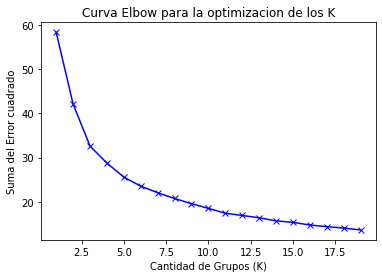

<Figure size 432x288 with 0 Axes>

In [10]:
# Con los datos normalizados..sin minutos
# Curva Eblow
import warnings
warnings.filterwarnings('ignore')

sum_of_squared_distances = []
K = range(1,20)
for k in K:
    k_means = KMeans(n_clusters=k)
    model = k_means.fit(normalize(df_00.iloc[:, 11:32]))
    sum_of_squared_distances.append(k_means.inertia_)

plt.plot(K, sum_of_squared_distances, 'bx-')
plt.xlabel('Cantidad de Grupos (K)')
plt.ylabel('Suma del Error cuadrado')
plt.title('Curva Elbow para la optimizacion de los K')
plt.show()
sb.despine(left=True, bottom=True)

# Se produce un Warning que puede ser por tener el script de streamlit en ejecución..se puede ignorar o setear la variable
# import warnings
# warnings.filterwarnings('ignore')
# import os
# os.environ["OMP_NUM_THREADS"] = '1'

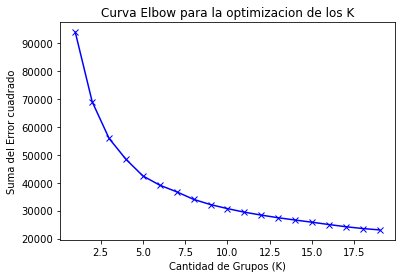

<Figure size 432x288 with 0 Axes>

In [11]:
# sin normalizar..
sum_of_squared_distances = []
K = range(1,20)
for k in K:
    k_means = KMeans(n_clusters=k)
    model = k_means.fit(df_00.iloc[:, 11:32])
    sum_of_squared_distances.append(k_means.inertia_)

plt.plot(K, sum_of_squared_distances, 'bx-')
plt.xlabel('Cantidad de Grupos (K)')
plt.ylabel('Suma del Error cuadrado')
plt.title('Curva Elbow para la optimizacion de los K')
plt.show()
sb.despine(left=True, bottom=True)

# Se produce un Warning que puede ser por tener el script de streamlit en ejecución..se puede ignorar o setear la variable
# import warnings
# warnings.filterwarnings('ignore')
# import os
# os.environ["OMP_NUM_THREADS"] = '1'

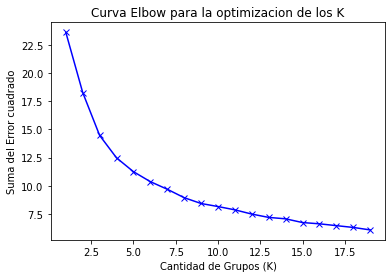

<Figure size 432x288 with 0 Axes>

In [12]:
# Curva Eblow...incluyendo los minutos que jugan en 100 posesiones con el jugador en cancha..
# Normalizado..

sum_of_squared_distances = []
K = range(1,20)
for k in K:
    k_means = KMeans(n_clusters=k, init="k-means++", random_state=0)
    model = k_means.fit(normalize(df_00.iloc[:, 10:32]))
    sum_of_squared_distances.append(k_means.inertia_)

plt.plot(K, sum_of_squared_distances, 'bx-')
plt.xlabel('Cantidad de Grupos (K)')
plt.ylabel('Suma del Error cuadrado')
plt.title('Curva Elbow para la optimizacion de los K')
plt.show()
sb.despine(left=True, bottom=True)


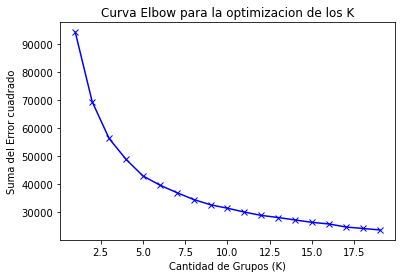

<Figure size 432x288 with 0 Axes>

In [13]:
# Curva Eblow...incluyendo los minutos que jugan en 100 posesiones con el jugador en cancha..
# sin normalizar..

sum_of_squared_distances = []
K = range(1,20)
for k in K:
    k_means = KMeans(n_clusters=k, init="k-means++", random_state=0)
    model = k_means.fit(df_00.iloc[:, 10:32])
    sum_of_squared_distances.append(k_means.inertia_)

plt.plot(K, sum_of_squared_distances, 'bx-')
plt.xlabel('Cantidad de Grupos (K)')
plt.ylabel('Suma del Error cuadrado')
plt.title('Curva Elbow para la optimizacion de los K')
plt.show()
sb.despine(left=True, bottom=True)


In [14]:
# GRAFICAR TEORIA DEL ELBOW A PARTIR DE "SILHOUETTE SCORE"...Internete
# !pip install yellowbrick

# # import numpy as np
# # import pandas as pd
# # from sklearn.cluster import KMeans 
# from yellowbrick.cluster import KElbowVisualizer

# def elbow(df,x,y,z):
#     df = df.dropna(subset=[x,y,z])
#     df_cluster = df[[x,y,z]]
#     cluster = np.array(df_cluster)

#     model = KMeans(random_state=123, init = 'k-means++', n_init = 10, max_iter=100) 

#     visualizer = KElbowVisualizer(model, k=(2,15), metric='silhouette', timings=False)

#     visualizer.fit(cluster)    
#     visualizer.poof()

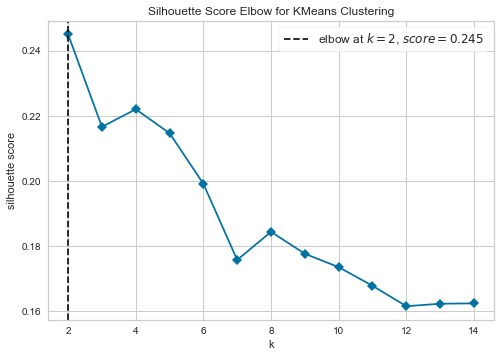

<AxesSubplot:title={'center':'Silhouette Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='silhouette score'>

In [15]:
from yellowbrick.cluster import KElbowVisualizer

# SIN MINUTOS SIN STANDARIZAR..

kmeans_model = KMeans(random_state=123, init = 'k-means++', n_init = 10, max_iter=100)
plot_elbow = KElbowVisualizer(kmeans_model, k=(2,15), metric='silhouette', timings=False)

plot_elbow.fit(df_00.iloc[:, 11:32])
plot_elbow.poof()

# En está grafica se observan perfectamente los codos que se producen en función del número de clusters, en función del
# contexto de los datos se ve claramente que un buen número de clusters es 7, 8 o 9...

In [18]:
# Crar modelo para standarizar los datos y que las pruebas de los algoritmos de ML sean algo más precisas (x reducir outlayer)
# o más bien suavizarlos, que son las muestras que pueden distorsionar los resultados..)

from sklearn.preprocessing import StandardScaler

mod_stdsc = StandardScaler()

In [ ]:
# Guardar modelo de standardScaler()


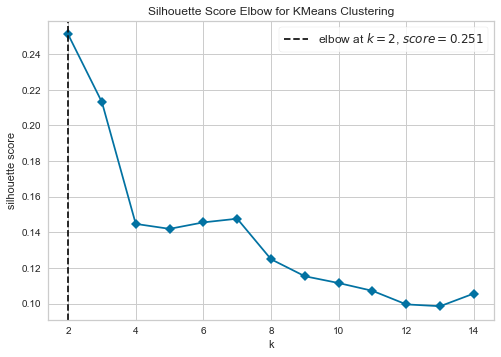

<AxesSubplot:title={'center':'Silhouette Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='silhouette score'>

In [19]:
data_00_stdsc = mod_stdsc.fit_transform(df_00.iloc[:, 11:32])
df_00_stdsc = pd.DataFrame(data_00_stdsc, columns=df_00.iloc[:, 11:32].columns)
 
plot_elbow = KElbowVisualizer(kmeans_model, k=(2,15), metric='silhouette', timings=False)
plot_elbow.fit(df_00_stdsc)
plot_elbow.poof()


In [20]:
# plot_elbow = KElbowVisualizer(kmeans_model, k=(2,15), metric='silhouette', timings=False)
# plot_elbow.fit(mod_stdsc.fit_transform(df_00.iloc[:, 11:32]))
# plot_elbow.poof()


### Se opta por dividir los datos en 7 clusters, tras observar los diferentes metodos para optener el mejor o más óptimo número de clusters, y entendiendo el contexto de los datos que se quieren segmentar..

- *** 8 cluster tambien hubiera sido una buena elección, ya que han ido aparenciendo nuevos roles alrededor de las posiciones clásicas de los jugadores de baloncesto..

## PRACTICA 1.
### CLUSTERING SIN PCA (Principal components analysis).

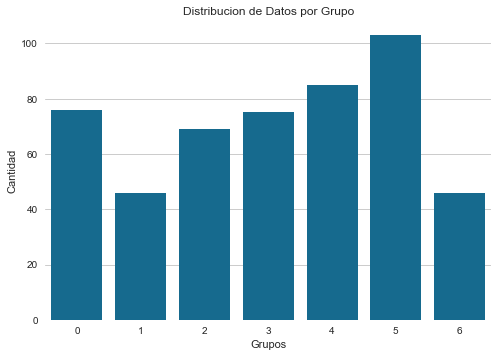

In [42]:
# Clusterización sin normalizar sin Minutos
mod_kmeans_optimo = KMeans(n_clusters=7,random_state=123, n_init=10, max_iter=100).fit(df_00.iloc[:, 11:32])
mod_predict = mod_kmeans_optimo.predict(df_00.iloc[:, 11:32])
clusters = mod_kmeans_optimo.labels_

#sns.set(color = 'w')
sb.countplot(clusters, color = 'b'  )
plt.title('Distribucion de Datos por Grupo')
plt.xlabel('Grupos')
plt.ylabel('Cantidad')
sb.despine(left=True, bottom=True)

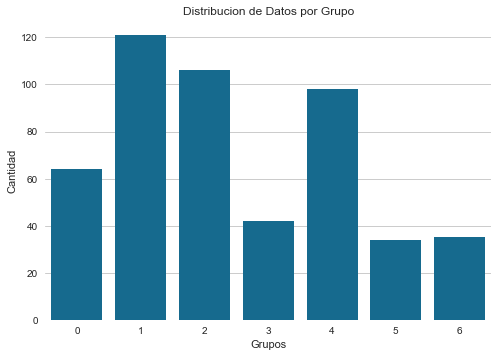

In [43]:
# Clusterización normalizando sin minutos
mod_kmeans_optimo = KMeans(n_clusters=7,random_state=123, n_init=10, max_iter=100).fit(normalize(df_00.iloc[:, 11:32]))
mod_predict = mod_kmeans_optimo.predict(normalize(df_00.iloc[:, 11:32]))
clusters = mod_kmeans_optimo.labels_

#sns.set(color = 'w')
sb.countplot(clusters, color = 'b'  )
plt.title('Distribucion de Datos por Grupo')
plt.xlabel('Grupos')
plt.ylabel('Cantidad')
sb.despine(left=True, bottom=True)

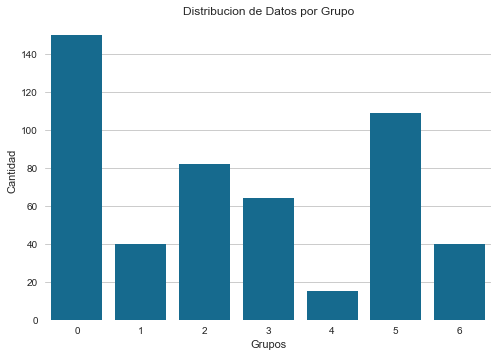

In [44]:
# Clusterización standarizando..SIN MINUTOS..
mod_kmeans_optimo = KMeans(n_clusters=7,random_state=123, n_init=10, max_iter=100).\
    fit(mod_stdsc.fit_transform(df_00.iloc[:, 11:32]))
mod_predict = mod_kmeans_optimo.predict(mod_stdsc.fit_transform(df_00.iloc[:, 11:32]))
clusters = mod_kmeans_optimo.labels_

#sns.set(color = 'w')
sb.countplot(clusters, color = 'b'  )
plt.title('Distribucion de Datos por Grupo')
plt.xlabel('Grupos')
plt.ylabel('Cantidad')
sb.despine(left=True, bottom=True)

### Utilizamos la última Clusterización...SIN Mints, solo Stadísticas por 100 posesiones...y datos standarizados
*** Al seguir profundizando en los datos nos damos cuenta que los MINUTOS no son importantes para diferenciar a los jugadores en la estadística de "por 100 posesiones", ya que casi todos los jugadores consumen un tiempo muy parecido tras 100 posessiones con el jugador en cancha..POR LO QUE, CLUSTERIZAMOS SIN INCLUIR LOS MINUTOS "MIN".

In [26]:
# Borrar columna cluster..
# df_00.drop("Cluster", axis=1, inplace=True)

In [45]:
# Añadir colmna cluster por index..xa no perder el contexto de las variables categóricas..
# df_00.insert(0,"Cluster", clusters)
df_00["Cluster"] = clusters
df_00.head()

,PLAYER_ID,PLAYER_NAME,NICKNAME,TEAM_ID,TEAM_ABBREVIATION,AGE,GP,W,L,W_PCT,MIN,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,FT_PCT,OREB,DREB,REB,AST,TOV,STL,BLK,BLKA,PF,PFD,PTS,PLUS_MINUS,SEASON,Cluster
0,203932,Aaron Gordon,Aaron,1610612743,DEN,26.0,75,46,29,0.613,48.4,8.8,17.0,0.520,1.8,5.3,0.335,3.5,4.7,0.743,2.5,6.4,8.9,3.8,2.7,0.9,0.9,1.1,3.0,4.1,22.9,6.5,2021-22,5
1,1628988,Aaron Holiday,Aaron,1610612756,PHX,25.0,63,34,29,0.540,48.3,7.1,16.0,0.447,1.8,4.9,0.379,2.8,3.2,0.868,1.1,4.6,5.8,7.2,3.2,2.0,0.4,0.9,4.4,3.5,18.9,-1.8,2021-22,3
2,1630174,Aaron Nesmith,Aaron,1610612738,BOS,22.0,52,32,20,0.615,48.0,6.0,15.2,0.396,2.6,9.6,0.270,1.8,2.2,0.808,1.3,6.2,7.4,1.8,2.6,1.7,0.4,0.2,5.9,2.3,16.4,1.8,2021-22,0
3,1630598,Aaron Wiggins,Aaron,1610612760,OKC,23.0,50,13,37,0.260,47.5,6.1,13.2,0.463,1.6,5.4,0.304,2.4,3.3,0.729,2.0,5.0,7.0,2.7,2.1,1.2,0.4,0.8,3.7,2.5,16.3,-9.2,2021-22,0
4,1627846,Abdel Nader,Abdel,1610612756,PHX,28.0,14,11,3,0.786,44.4,3.7,10.7,0.343,1.2,4.3,0.286,1.8,3.1,0.600,1.2,7.0,8.3,2.1,3.4,2.4,1.2,0.6,6.1,4.3,10.4,-0.6,2021-22,3


In [49]:
# Comprobaciones..
# print(len(df_00))
# print(len(df_00[df_00.GP < 10]))

500
0


In [51]:
# Reiniciar el index, ya que al haber filtrado para eliminar jugadores que hayan jugado poco, el index se ha desordenado..
df_00.reset_index(drop=True, inplace=True)
df_00.head()

,PLAYER_ID,PLAYER_NAME,NICKNAME,TEAM_ID,TEAM_ABBREVIATION,AGE,GP,W,L,W_PCT,MIN,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,FT_PCT,OREB,DREB,REB,AST,TOV,STL,BLK,BLKA,PF,PFD,PTS,PLUS_MINUS,SEASON,Cluster
0,203932,Aaron Gordon,Aaron,1610612743,DEN,26.0,75,46,29,0.613,48.4,8.8,17.0,0.520,1.8,5.3,0.335,3.5,4.7,0.743,2.5,6.4,8.9,3.8,2.7,0.9,0.9,1.1,3.0,4.1,22.9,6.5,2021-22,5
1,1628988,Aaron Holiday,Aaron,1610612756,PHX,25.0,63,34,29,0.540,48.3,7.1,16.0,0.447,1.8,4.9,0.379,2.8,3.2,0.868,1.1,4.6,5.8,7.2,3.2,2.0,0.4,0.9,4.4,3.5,18.9,-1.8,2021-22,3
2,1630174,Aaron Nesmith,Aaron,1610612738,BOS,22.0,52,32,20,0.615,48.0,6.0,15.2,0.396,2.6,9.6,0.270,1.8,2.2,0.808,1.3,6.2,7.4,1.8,2.6,1.7,0.4,0.2,5.9,2.3,16.4,1.8,2021-22,0
3,1630598,Aaron Wiggins,Aaron,1610612760,OKC,23.0,50,13,37,0.260,47.5,6.1,13.2,0.463,1.6,5.4,0.304,2.4,3.3,0.729,2.0,5.0,7.0,2.7,2.1,1.2,0.4,0.8,3.7,2.5,16.3,-9.2,2021-22,0
4,1627846,Abdel Nader,Abdel,1610612756,PHX,28.0,14,11,3,0.786,44.4,3.7,10.7,0.343,1.2,4.3,0.286,1.8,3.1,0.600,1.2,7.0,8.3,2.1,3.4,2.4,1.2,0.6,6.1,4.3,10.4,-0.6,2021-22,3


In [52]:
df_00.Cluster.value_counts()

0    150
5    109
2     82
3     64
6     40
1     40
4     15
Name: Cluster, dtype: int64

In [53]:
df_00.groupby(by="Cluster").mean()

,PLAYER_ID,TEAM_ID,AGE,GP,W,L,W_PCT,MIN,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,FT_PCT,OREB,DREB,REB,AST,TOV,STL,BLK,BLKA,PF,PFD,PTS,PLUS_MINUS
Cluster,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,1.322260e+06,1.610613e+09,26.206667,50.013333,25.780000,24.233333,0.507013,47.806667,5.660000,13.339333,0.426960,2.414667,7.080000,0.340047,1.742000,2.288667,0.768033,1.780667,5.840000,7.615333,3.138000,1.692000,1.471333,0.812000,0.651333,3.935333,2.264000,15.484667,-1.463333
1,9.463819e+05,1.610613e+09,26.900000,59.225000,32.775000,26.450000,0.548025,48.137500,11.802500,25.440000,0.463100,2.920000,8.345000,0.342375,6.692500,8.142500,0.826150,1.515000,7.557500,9.065000,7.937500,4.197500,1.562500,0.767500,1.372500,3.390000,6.662500,33.207500,2.800000
2,1.258869e+06,1.610613e+09,26.121951,51.036585,23.304878,27.731707,0.449244,47.679268,8.669512,16.563415,0.526463,1.187805,3.746341,0.323793,3.768293,5.291463,0.717415,4.264634,9.081707,13.340244,3.081707,2.767073,1.224390,1.696341,1.134146,5.815854,4.860976,22.282927,-2.069512
3,1.182102e+06,1.610613e+09,26.281250,45.968750,22.093750,23.875000,0.475187,47.548437,6.293750,14.976562,0.419594,1.562500,5.210938,0.287094,2.671875,3.756250,0.718047,1.473437,5.518750,6.990625,7.635937,3.317188,2.167187,0.664062,1.053125,4.195312,3.664062,16.828125,-4.032813
4,1.439491e+06,1.610613e+09,25.400000,17.133333,9.666667,7.466667,0.583133,47.433333,4.046667,12.440000,0.321667,2.360000,7.440000,0.310200,0.386667,1.093333,0.198933,1.773333,5.560000,7.333333,3.400000,1.906667,0.946667,0.566667,0.853333,4.246667,1.506667,10.860000,-13.620000
5,1.102920e+06,1.610613e+09,26.678899,60.761468,30.532110,30.229358,0.492183,47.911009,8.505505,19.842202,0.429716,3.615596,9.833028,0.367697,3.179817,3.899083,0.818734,1.105505,5.254128,6.354128,4.755963,2.384404,1.395413,0.541284,0.944037,3.396330,3.421101,23.808257,-0.119266
6,1.130106e+06,1.610613e+09,25.925000,43.900000,24.075000,19.825000,0.527950,48.060000,6.812500,11.415000,0.598650,0.040000,0.390000,0.023975,2.810000,4.567500,0.606550,5.687500,10.582500,16.277500,2.525000,2.212500,1.387500,2.287500,1.025000,5.932500,4.250000,16.462500,-0.355000


In [54]:
# media de las variables...formateando el dato de salida.
df_00.mean().map('{:,.2f}'.format)

PLAYER_ID         1,204,181.76
TEAM_ID       1,610,612,751.40
AGE                      26.31
GP                       51.27
W                        25.88
L                        25.39
W_PCT                     0.50
MIN                      47.81
FGM                       7.39
FGA                      16.28
FG_PCT                    0.46
FG3M                      2.21
FG3A                      6.47
FG3_PCT                   0.31
FTM                       2.95
FTA                       3.93
FT_PCT                    0.74
OREB                      2.29
DREB                      6.71
REB                       9.00
AST                       4.40
TOV                       2.48
STL                       1.49
BLK                       0.99
BLKA                      0.94
PF                        4.29
PFD                       3.61
PTS                      19.94
PLUS_MINUS               -1.53
Cluster                   2.48
dtype: object

In [55]:
# media de puntos por partido y jugador..
df_00.PTS.mean()

19.943399999999993

In [56]:
# Agrupar por Cluster y Optener las medias de las variables utilizadas en el modelo KMeans..
# De esta informaciñon se puede obtener una primera contextualización de cada cluster..

df_00.groupby(by="Cluster").mean().iloc[:,7:]

,MIN,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,FT_PCT,OREB,DREB,REB,AST,TOV,STL,BLK,BLKA,PF,PFD,PTS,PLUS_MINUS
Cluster,,,,,,,,,,,,,,,,,,,,,,
0,47.806667,5.660000,13.339333,0.426960,2.414667,7.080000,0.340047,1.742000,2.288667,0.768033,1.780667,5.840000,7.615333,3.138000,1.692000,1.471333,0.812000,0.651333,3.935333,2.264000,15.484667,-1.463333
1,48.137500,11.802500,25.440000,0.463100,2.920000,8.345000,0.342375,6.692500,8.142500,0.826150,1.515000,7.557500,9.065000,7.937500,4.197500,1.562500,0.767500,1.372500,3.390000,6.662500,33.207500,2.800000
2,47.679268,8.669512,16.563415,0.526463,1.187805,3.746341,0.323793,3.768293,5.291463,0.717415,4.264634,9.081707,13.340244,3.081707,2.767073,1.224390,1.696341,1.134146,5.815854,4.860976,22.282927,-2.069512
3,47.548437,6.293750,14.976562,0.419594,1.562500,5.210938,0.287094,2.671875,3.756250,0.718047,1.473437,5.518750,6.990625,7.635937,3.317188,2.167187,0.664062,1.053125,4.195312,3.664062,16.828125,-4.032813
4,47.433333,4.046667,12.440000,0.321667,2.360000,7.440000,0.310200,0.386667,1.093333,0.198933,1.773333,5.560000,7.333333,3.400000,1.906667,0.946667,0.566667,0.853333,4.246667,1.506667,10.860000,-13.620000
5,47.911009,8.505505,19.842202,0.429716,3.615596,9.833028,0.367697,3.179817,3.899083,0.818734,1.105505,5.254128,6.354128,4.755963,2.384404,1.395413,0.541284,0.944037,3.396330,3.421101,23.808257,-0.119266
6,48.060000,6.812500,11.415000,0.598650,0.040000,0.390000,0.023975,2.810000,4.567500,0.606550,5.687500,10.582500,16.277500,2.525000,2.212500,1.387500,2.287500,1.025000,5.932500,4.250000,16.462500,-0.355000


In [57]:
df_00.groupby(by="Cluster").describe()[["MIN","FG_PCT","FG3_PCT","AST","REB","PTS","PLUS_MINUS"]]

MIN                                                        FG_PCT  \
         count       mean       std   min     25%   50%     75%   max  count   
Cluster                                                                        
0        150.0  47.806667  1.008731  44.1  47.200  47.8  48.400  50.6  150.0   
1         40.0  48.137500  0.936356  46.4  47.400  48.2  48.925  50.0   40.0   
2         82.0  47.679268  1.086135  43.1  47.100  47.7  48.300  50.6   82.0   
3         64.0  47.548437  1.034944  44.4  46.900  47.6  48.300  49.7   64.0   
4         15.0  47.433333  1.578275  44.4  46.100  47.7  48.450  50.1   15.0   
5        109.0  47.911009  0.978977  45.7  47.200  47.9  48.600  50.1  109.0   
6         40.0  48.060000  0.980528  45.7  47.375  48.2  48.600  49.8   40.0   

                                                                    FG3_PCT  \
             mean       std    min      25%     50%      75%    max   count   
Cluster                                                                       
0        0.426960  0.066602  0.125  0.39325  0.4230  0.46300  0.616   150.0   
1        0.463100  0.039737  0.402  0.44150  0.4580  0.47700  0.583    40.0   
2        0.526463  0.067952  0.333  0.48675  0.5175  0.56825  0.671    82.0   
3        0.419594  0.054533  0.231  0.38300  0.4185  0.45700  0.525    64.0   
4        0.321667  0.096919  0.150  0.25350  0.3110  0.38600  0.500    15.0   
5        0.429716  0.035025  0.319  0.40300  0.4310  0.45500  0.520   109.0   
6        0.598650  0.091350  0.417  0.53300  0.5930  0.67475  0.761    40.0   

                                                                      AST  \
             mean       std    min     25%     50%      75%    max  count   
Cluster                                                                     
0        0.340047  0.060385  0.083  0.3070  0.3400  0.37750  0.583  150.0   
1        0.342375  0.041351  0.233  0.3115  0.3480  0.37475  0.418   40.0   
2        0.323793  0.117108  0.000  0.2725  0.3175  0.35700  1.000   82.0   
3        0.287094  0.072508  0.000  0.2350  0.2960  0.33925  0.414   64.0   
4        0.310200  0.109402  0.125  0.2500  0.3210  0.37850  0.500   15.0   
5        0.367697  0.039031  0.270  0.3410  0.3680  0.39200  0.500  109.0   
6        0.023975  0.063319  0.000  0.0000  0.0000  0.00000  0.250   40.0   

                                                              REB             \
             mean       std  min    25%   50%    75%   max  count       mean   
Cluster                                                                        
0        3.138000  1.408920  1.0  2.200  2.80  3.800   9.1  150.0   7.615333   
1        7.937500  2.582951  3.5  6.250  7.95  9.075  13.3   40.0   9.065000   
2        3.081707  1.360204  0.7  2.200  2.70  3.775   7.3   82.0  13.340244   
3        7.635937  2.608799  2.1  5.775  8.05  9.175  15.7   64.0   6.990625   
4        3.400000  1.919821  0.6  2.450  2.70  4.550   8.0   15.0   7.333333   
5        4.755963  2.178915  0.9  3.100  4.30  6.300  10.4  109.0   6.354128   
6        2.525000  1.411083  0.0  1.700  2.30  3.225   6.2   40.0  16.277500   

                                                        PTS             \
              std   min     25%    50%     75%   max  count       mean   
Cluster                                                                  
0        2.277928   3.2   5.825   7.35   9.075  12.9  150.0  15.484667   
1        3.573087   4.5   6.375   8.30  10.600  19.8   40.0  33.207500   
2        2.832957   8.1  11.400  12.70  15.375  20.0   82.0  22.282927   
3        2.048361   4.6   5.700   6.35   7.525  12.4   64.0  16.828125   
4        2.213164   3.2   5.900   7.70   8.350  12.4   15.0  10.860000   
5        2.058970   3.2   5.000   6.10   7.200  15.4  109.0  23.808257   
6        2.859486  11.0  14.500  16.00  18.225  23.0   40.0  16.462500   

                                                    PLUS_MINUS             \
              std   min     2

In [58]:
# Medias de cada variable para todo el conjunto de datos..
pd.DataFrame(df_00.mean()[8:]) #, columns=df_00.iloc[0,7:].columns)

,0
FGM,7.390200
FGA,16.282400
FG_PCT,0.456404
FG3M,2.215000
FG3A,6.471000
FG3_PCT,0.310636
FTM,2.947600
FTA,3.934800
FT_PCT,0.739044
OREB,2.292600


In [62]:
# Comparando las medias de los clusters con la medias del conjunto de datos...XA CONTEXTUALIZAR LOS CLUSTERS..
# *** Con esta instruccón se observa que cluster esta por encima o por debajo de la media general
# Dependiendo de la estadística sera bueno que este en positivo (x encima de la media) o negativo (Por debajo de la media)..
# un negativo bueno seria estar por debajo de la medi en perdidas (TOV)
df_00.groupby(by="Cluster").mean().iloc[:,8:29] - df_00.iloc[:,11:32].mean()

,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,FT_PCT,OREB,DREB,REB,AST,TOV,STL,BLK,BLKA,PF,PFD,PTS,PLUS_MINUS
Cluster,,,,,,,,,,,,,,,,,,,,,
0,-1.730200,-2.943067,-0.029444,0.199667,0.609000,0.029411,-1.205600,-1.646133,0.028989,-0.511933,-0.871200,-1.384467,-1.262000,-0.783800,-0.016867,-0.174200,-0.288067,-0.349667,-1.345400,-4.458733,0.070267
1,4.412300,9.157600,0.006696,0.705000,1.874000,0.031739,3.744900,4.207700,0.087106,-0.777600,0.846300,0.065200,3.537500,1.721700,0.074300,-0.218700,0.433100,-0.895000,3.053100,13.264100,4.333600
2,1.279312,0.281015,0.070059,-1.027195,-2.724659,0.013157,0.820693,1.356663,-0.021629,1.972034,2.370507,4.340444,-1.318293,0.291273,-0.263810,0.710141,0.194746,1.530854,1.251576,2.339527,-0.535912
3,-1.096450,-1.305837,-0.036810,-0.652500,-1.260063,-0.023542,-0.275725,-0.178550,-0.020997,-0.819163,-1.192450,-2.009175,3.235938,0.841387,0.678987,-0.322138,0.113725,-0.089688,0.054663,-3.115275,-2.499213
4,-3.343533,-3.842400,-0.134737,0.145000,0.969000,-0.000436,-2.560933,-2.841467,-0.540111,-0.519267,-1.151200,-1.666467,-1.000000,-0.569133,-0.541533,-0.419533,-0.086067,-0.038333,-2.102733,-9.083400,-12.086400
5,1.115305,3.559802,-0.026688,1.400596,3.362028,0.057061,0.232217,-0.035717,0.079690,-1.187095,-1.457072,-2.645672,0.355963,-0.091396,-0.092787,-0.444916,0.004637,-0.888670,-0.188299,3.864857,1.414334
6,-0.577700,-4.867400,0.142246,-2.175000,-6.081000,-0.286661,-0.137600,0.632700,-0.132494,3.394900,3.871300,7.277700,-1.875000,-0.263300,-0.100700,1.301300,0.085600,1.647500,0.640600,-3.480900,1.178600


In [ ]:
# Buena Práctica sería obtener los mejores jugadores de cada cluster en algunos de los atributos más importantes de las
# estadísticas por 100 posesiones..

# Esto estaría relacionado con las desviaciones estandar de la función de densidad de cada atributo para cada cluster,
# pudiendo decir que xa atributos q es mejor estar x encima de la media, los mejores jugadores serán los que están en el 
# fuera del rango del 95% de los datos de un distribución normal..

### Contextualizando los CLUSTERS..observando los % de eficiencia, alguna stadistica tradicional y para evaluar su eficiencia para el equipo el plus_minus..
- Cluster "0": Son de los que más asisten xo puntuan por debajo de la media de 19.94, tiran poco de 3 y bastante de 2 pero no son muy eficientes, y cuando estan en cancha el +- para su equipo es de -3 puntos ( Podemos decir que son bases suplentes..6º Hombres..xejemplo)
- Cluster "1"[OK]: Asisten de los que mas, son los que mas puntuan y rebotean la media, tiran mucho de media distancias y son muy eficientes en ese tiro y tiran bastante de 3 con una eficiencia media, son de los que mas van a la linea de tiros libres y son los mas eficientes en esta faceta, su +- es el mejor..(Bases y escoltas tirulares..)
- Cluster "2": Asisten poco, son los que menos puntuan y rebotean poco, tiran bastante de 3 puntos y con buena eficiencia, pero de 2 puntos tiran poco y con poca eficiencia,su +- es negativo (escoltas-forwards especialistas en tiro suplentes..shooter)
- Cluster "3": Asisten bien, son los que mas puntuan y rebotean bien, son de los que mas tiran de 2 y 3 con eficiencia x encima de la media en ambos, y su plus minus es el mejor +2,81 puntos (podemos decir que son bases o escoltas titulares..)
- Cluster "4":
- Cluster "5":
- Cluster "6": 

In [37]:
df_00.head()

,PLAYER_ID,PLAYER_NAME,NICKNAME,TEAM_ID,TEAM_ABBREVIATION,AGE,GP,W,L,W_PCT,MIN,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,FT_PCT,OREB,DREB,REB,AST,TOV,STL,BLK,BLKA,PF,PFD,PTS,PLUS_MINUS,SEASON,Cluster
0,203932,Aaron Gordon,Aaron,1610612743,DEN,26.0,75,46,29,0.613,48.4,8.8,17.0,0.520,1.8,5.3,0.335,3.5,4.7,0.743,2.5,6.4,8.9,3.8,2.7,0.9,0.9,1.1,3.0,4.1,22.9,6.5,2021-22,2
1,1628988,Aaron Holiday,Aaron,1610612756,PHX,25.0,63,34,29,0.540,48.3,7.1,16.0,0.447,1.8,4.9,0.379,2.8,3.2,0.868,1.1,4.6,5.8,7.2,3.2,2.0,0.4,0.9,4.4,3.5,18.9,-1.8,2021-22,1
2,1630174,Aaron Nesmith,Aaron,1610612738,BOS,22.0,52,32,20,0.615,48.0,6.0,15.2,0.396,2.6,9.6,0.270,1.8,2.2,0.808,1.3,6.2,7.4,1.8,2.6,1.7,0.4,0.2,5.9,2.3,16.4,1.8,2021-22,3
3,1630598,Aaron Wiggins,Aaron,1610612760,OKC,23.0,50,13,37,0.260,47.5,6.1,13.2,0.463,1.6,5.4,0.304,2.4,3.3,0.729,2.0,5.0,7.0,2.7,2.1,1.2,0.4,0.8,3.7,2.5,16.3,-9.2,2021-22,3
4,1627846,Abdel Nader,Abdel,1610612756,PHX,28.0,14,11,3,0.786,44.4,3.7,10.7,0.343,1.2,4.3,0.286,1.8,3.1,0.600,1.2,7.0,8.3,2.1,3.4,2.4,1.2,0.6,6.1,4.3,10.4,-0.6,2021-22,3


### Vsualizaciones.. 

In [38]:
df_00.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 34 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   PLAYER_ID          500 non-null    int64  
 1   PLAYER_NAME        500 non-null    object 
 2   NICKNAME           500 non-null    object 
 3   TEAM_ID            500 non-null    int64  
 4   TEAM_ABBREVIATION  500 non-null    object 
 5   AGE                500 non-null    float64
 6   GP                 500 non-null    int64  
 7   W                  500 non-null    int64  
 8   L                  500 non-null    int64  
 9   W_PCT              500 non-null    float64
 10  MIN                500 non-null    float64
 11  FGM                500 non-null    float64
 12  FGA                500 non-null    float64
 13  FG_PCT             500 non-null    float64
 14  FG3M               500 non-null    float64
 15  FG3A               500 non-null    float64
 16  FG3_PCT            500 non

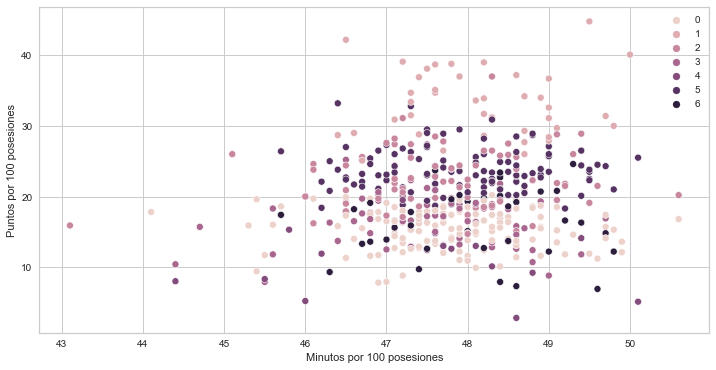

In [63]:
plt.figure(figsize=(12,6))
sb.scatterplot(x=df_00.iloc[:,10], y=df_00.iloc[:,30], hue=mod_kmeans_optimo.labels_)
plt.xlabel('Minutos por 100 posesiones')
plt.ylabel('Puntos por 100 posesiones')
plt.show()

In [65]:
from sklearn.preprocessing import MinMaxScaler

Mod_minmax = MinMaxScaler()
data_00_minmax = Mod_minmax.fit_transform(df_00.iloc[:,11:32])
data_00_minmax[:3]

array([[0.52702703, 0.4924812 , 0.62106918, 0.24324324, 0.28804348,
        0.335     , 0.24822695, 0.2716763 , 0.743     , 0.25      ,
        0.30136986, 0.28787879, 0.24203822, 0.42857143, 0.16981132,
        0.18367347, 0.32352941, 0.21505376, 0.328     , 0.47857143,
        0.82073814],
       [0.41216216, 0.45488722, 0.50628931, 0.24324324, 0.26630435,
        0.379     , 0.19858156, 0.1849711 , 0.868     , 0.11      ,
        0.17808219, 0.13131313, 0.45859873, 0.50793651, 0.37735849,
        0.08163265, 0.26470588, 0.3655914 , 0.28      , 0.38333333,
        0.67486819],
       [0.33783784, 0.42481203, 0.42610063, 0.35135135, 0.52173913,
        0.27      , 0.12765957, 0.12716763, 0.808     , 0.13      ,
        0.28767123, 0.21212121, 0.11464968, 0.41269841, 0.32075472,
        0.08163265, 0.05882353, 0.52688172, 0.184     , 0.32380952,
        0.73813708]])

In [66]:
df_00_minmax = pd.DataFrame(data_00_minmax, columns=df_00.iloc[:,11:32].columns)
df_00_minmax.head()

,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,FT_PCT,OREB,DREB,REB,AST,TOV,STL,BLK,BLKA,PF,PFD,PTS,PLUS_MINUS
0,0.527027,0.492481,0.621069,0.243243,0.288043,0.335,0.248227,0.271676,0.743,0.25,0.301370,0.287879,0.242038,0.428571,0.169811,0.183673,0.323529,0.215054,0.328,0.478571,0.820738
1,0.412162,0.454887,0.506289,0.243243,0.266304,0.379,0.198582,0.184971,0.868,0.11,0.178082,0.131313,0.458599,0.507937,0.377358,0.081633,0.264706,0.365591,0.280,0.383333,0.674868
2,0.337838,0.424812,0.426101,0.351351,0.521739,0.270,0.127660,0.127168,0.808,0.13,0.287671,0.212121,0.114650,0.412698,0.320755,0.081633,0.058824,0.526882,0.184,0.323810,0.738137
3,0.344595,0.349624,0.531447,0.216216,0.293478,0.304,0.170213,0.190751,0.729,0.20,0.205479,0.191919,0.171975,0.333333,0.226415,0.081633,0.235294,0.290323,0.200,0.321429,0.544815
4,0.182432,0.255639,0.342767,0.162162,0.233696,0.286,0.127660,0.179191,0.600,0.12,0.342466,0.257576,0.133758,0.539683,0.452830,0.244898,0.176471,0.548387,0.344,0.180952,0.695958


In [73]:
df_00_minmax.iloc[:, -2]

0      0.478571
1      0.383333
2      0.323810
3      0.321429
4      0.180952
         ...   
495    0.130952
496    0.409524
497    0.740476
498    0.378571
499    0.345238
Name: PTS, Length: 500, dtype: float64

In [ ]:
df_00_minmax.info()

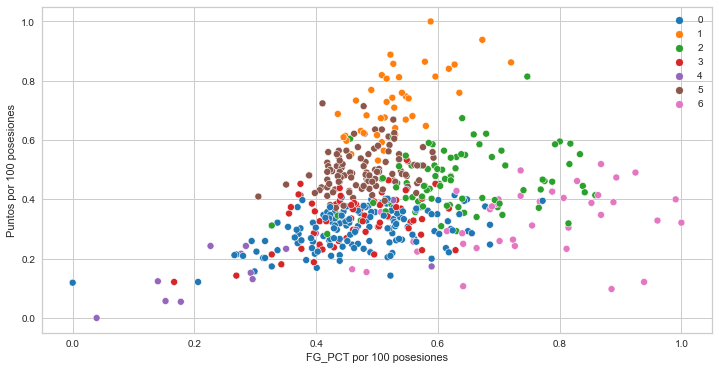

In [75]:
plt.figure(figsize=(12,6))
sb.scatterplot(x=df_00_minmax.iloc[:, 2], \
               y=df_00_minmax.iloc[:, -2], hue=mod_kmeans_optimo.labels_, palette="tab10")
plt.xlabel('FG_PCT por 100 posesiones')
plt.ylabel('Puntos por 100 posesiones')
plt.show()

## PRACTICA 2.
## CON PCA.. con 3 componentes principales para plotear 3D..
### PCA. Sobre los datos standarizados con StandardScaler()..

In [78]:
# Sin Incluir los Minutos..por estadisticas de 100posesiones este atributo es irrelevante..
from sklearn.decomposition import PCA
Mod_pca3 = PCA(n_components=3).fit(mod_stdsc.fit_transform(df_00.iloc[:, 11:32]))
print(Mod_pca3.components_)

data_00_stdsc_pca3 = Mod_pca3.transform(mod_stdsc.fit_transform(df_00.iloc[:, 11:32]))
data_00_stdsc_pca3[:5]

[[ 0.23714448  0.10618374  0.26549926 -0.21029173 -0.22189886 -0.15349679
   0.27944563  0.31586796 -0.03018615  0.26760364  0.29737655  0.31495958
   0.01326791  0.19493778 -0.02634653  0.23300992  0.18606537  0.16880947
   0.32101813  0.20645545  0.07070357]
 [ 0.28420622  0.37102275 -0.10598645  0.27784042  0.27752499  0.20135115
   0.2470053   0.18922484  0.21086936 -0.24227441 -0.11943696 -0.18658018
   0.22537749  0.20063561  0.02616851 -0.19350135  0.09445944 -0.19994639
   0.16692615  0.33975674  0.07171458]
 [-0.17748024 -0.06400496 -0.24136027 -0.2732843  -0.19341944 -0.22574399
   0.03983028  0.07317299 -0.15284724 -0.07915433 -0.17819882 -0.15249703
   0.42168142  0.35221073  0.30618939 -0.18578186  0.28295065  0.04638328
   0.11385178 -0.17899304 -0.30686698]]


array([[ 0.84758305,  0.62111747, -0.76232676],
       [-0.91863398,  0.81875016,  1.30726621],
       [-1.88654537, -0.58863933, -0.52057934],
       [-1.31406875, -0.95993682,  0.35453108],
       [-0.90753346, -2.17522041,  1.61086488]])

In [110]:
# Save modelo PCA
pickle.dump(Mod_pca3, open("models_ml/Model_pca3_players100possesion_202122.sav", 'wb'))

In [79]:
# convertimos en dataframe
df_00_stdsc_pca3 = pd.DataFrame(data_00_stdsc_pca3, columns=["PCA_1","PCA_2","PCA_3"])
df_00_stdsc_pca3.head()

,PCA_1,PCA_2,PCA_3
0,0.847583,0.621117,-0.762327
1,-0.918634,0.818750,1.307266
2,-1.886545,-0.588639,-0.520579
3,-1.314069,-0.959937,0.354531
4,-0.907533,-2.175220,1.610865


In [80]:
# Pasamos los nombres de jugadores en orden de indice, a una lista
player_hover = df_00.PLAYER_NAME
player_hover[:5]

0     Aaron Gordon
1    Aaron Holiday
2    Aaron Nesmith
3    Aaron Wiggins
4      Abdel Nader
Name: PLAYER_NAME, dtype: object

In [90]:
# Clusterizamos el conjunto de datos con 3 componentes principales..agregamos la columna labels(clusters), y graficamos 3D
mod_km_pca3 = KMeans(random_state = 123, n_init = 10, max_iter=100, n_clusters=7)
mod_km_pca3.fit(df_00_stdsc_pca3)

df_00_stdsc_pca3['Cluster_pca3'] = mod_km_pca3.labels_

fig = px.scatter_3d(df_00_stdsc_pca3, x=df_00_stdsc_pca3.PCA_1, y=df_00_stdsc_pca3.PCA_2, \
                    z=df_00_stdsc_pca3.PCA_3, color = df_00_stdsc_pca3['Cluster_pca3'], \
                    height = 600, width = 800, hover_name = df_00.PLAYER_NAME)
fig.show()

In [111]:
# save de model..
pickle.dump(mod_km_pca3, open("models_ml/Model_km_pca3_players100possesion_202122.sav", 'wb'))

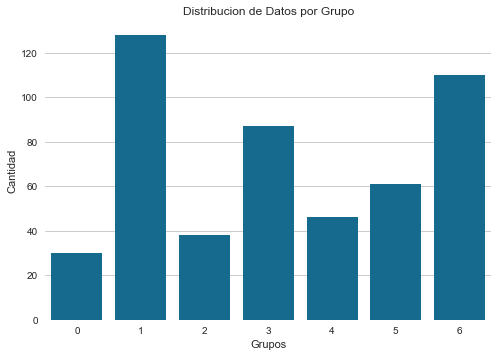

In [91]:
# Contamos el número de muestras en cada cluster de pca3
sb.countplot(mod_km_pca3.labels_, color = 'b'  )
plt.title('Distribucion de Datos por Grupo')
plt.xlabel('Grupos')
plt.ylabel('Cantidad')
sb.despine(left=True, bottom=True)

In [92]:
#df_00_stdsc_pca3.drop(["Cluster", "Cluster_pca3"], axis=1, inplace=True)
df_00_stdsc_pca3.head()

,PCA_1,PCA_2,PCA_3,Cluster_pca3
0,0.847583,0.621117,-0.762327,3
1,-0.918634,0.818750,1.307266,5
2,-1.886545,-0.588639,-0.520579,1
3,-1.314069,-0.959937,0.354531,1
4,-0.907533,-2.175220,1.610865,5


In [93]:
# Añádimos tb la clusterización a parte de al df de pca3..al conjto de datos completo df_00(Para contextualizar...)
# df_00.drop("Cluster_pca3", axis=1, inplace=True)
df_00["Cluster_pca3"] = mod_km_pca3.labels_
df_00.head()

,PLAYER_ID,PLAYER_NAME,NICKNAME,TEAM_ID,TEAM_ABBREVIATION,AGE,GP,W,L,W_PCT,MIN,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,FT_PCT,OREB,DREB,REB,AST,TOV,STL,BLK,BLKA,PF,PFD,PTS,PLUS_MINUS,SEASON,Cluster,Cluster_pca3
0,203932,Aaron Gordon,Aaron,1610612743,DEN,26.0,75,46,29,0.613,48.4,8.8,17.0,0.520,1.8,5.3,0.335,3.5,4.7,0.743,2.5,6.4,8.9,3.8,2.7,0.9,0.9,1.1,3.0,4.1,22.9,6.5,2021-22,5,3
1,1628988,Aaron Holiday,Aaron,1610612756,PHX,25.0,63,34,29,0.540,48.3,7.1,16.0,0.447,1.8,4.9,0.379,2.8,3.2,0.868,1.1,4.6,5.8,7.2,3.2,2.0,0.4,0.9,4.4,3.5,18.9,-1.8,2021-22,3,5
2,1630174,Aaron Nesmith,Aaron,1610612738,BOS,22.0,52,32,20,0.615,48.0,6.0,15.2,0.396,2.6,9.6,0.270,1.8,2.2,0.808,1.3,6.2,7.4,1.8,2.6,1.7,0.4,0.2,5.9,2.3,16.4,1.8,2021-22,0,1
3,1630598,Aaron Wiggins,Aaron,1610612760,OKC,23.0,50,13,37,0.260,47.5,6.1,13.2,0.463,1.6,5.4,0.304,2.4,3.3,0.729,2.0,5.0,7.0,2.7,2.1,1.2,0.4,0.8,3.7,2.5,16.3,-9.2,2021-22,0,1
4,1627846,Abdel Nader,Abdel,1610612756,PHX,28.0,14,11,3,0.786,44.4,3.7,10.7,0.343,1.2,4.3,0.286,1.8,3.1,0.600,1.2,7.0,8.3,2.1,3.4,2.4,1.2,0.6,6.1,4.3,10.4,-0.6,2021-22,3,5


In [94]:
# Agrupar por Cluster y Obtener las medias de las variables utilizadas en el modelo KMeans..
# De esta informaciñon se puede obtener una primera contextualización de cada cluster..

df_00.groupby(by="Cluster_pca3").mean().iloc[:,8:]

,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,FT_PCT,OREB,DREB,REB,AST,TOV,STL,BLK,BLKA,PF,PFD,PTS,PLUS_MINUS,Cluster
Cluster_pca3,,,,,,,,,,,,,,,,,,,,,,
0,6.316667,10.693333,0.595900,0.050000,0.326667,0.046833,2.416667,4.010000,0.598833,5.673333,10.030000,15.716667,2.483333,2.243333,1.366667,2.296667,1.010000,6.083333,3.846667,15.080000,-1.330000,5.600000
1,5.347656,13.160156,0.407492,2.664844,7.744531,0.342664,1.427344,1.891406,0.720547,1.585938,5.503125,7.086719,3.158594,1.600781,1.410156,0.717187,0.575781,3.897656,1.987500,14.800781,-2.302344,0.414062
2,9.150000,15.705263,0.586895,0.381579,1.265789,0.253763,4.468421,6.492105,0.685395,5.410526,10.597368,16.000000,3.171053,3.002632,1.278947,2.073684,1.250000,6.015789,5.836842,23.131579,0.284211,3.052632
3,7.455172,15.236782,0.491598,1.540230,4.793103,0.317253,2.791954,3.894253,0.719828,3.326437,7.981609,11.298851,3.129885,2.212644,1.381609,1.355172,0.935632,4.903448,3.552874,19.233333,-1.942529,1.620690
4,11.663043,24.919565,0.467609,2.839130,8.169565,0.339587,6.528261,8.073913,0.811587,1.693478,7.913043,9.597826,7.295652,4.143478,1.519565,0.871739,1.397826,3.817391,6.719565,32.684783,2.623913,1.130435
5,5.906557,14.662295,0.401443,1.436066,5.078689,0.273721,2.500000,3.544262,0.705115,1.359016,5.081967,6.440984,7.245902,3.257377,2.059016,0.622951,1.134426,4.201639,3.534426,15.759016,-6.134426,2.885246
6,8.436364,19.752727,0.428155,3.620000,9.851818,0.368091,3.210000,3.926364,0.821018,1.066364,5.265455,6.326364,5.007273,2.452727,1.439091,0.523636,0.939091,3.400000,3.448182,23.706364,-0.186364,4.863636


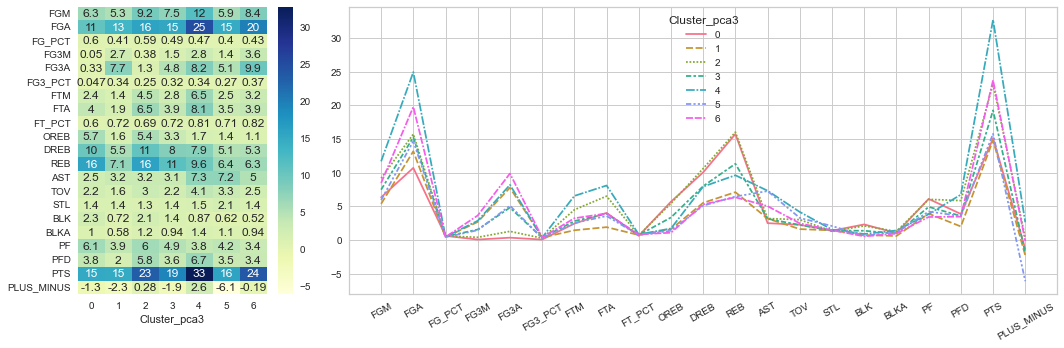

In [120]:
# Graficando las medias de los atributos de cada Cluster..
fig, axs = plt.subplots(1,2,figsize=(15,5), gridspec_kw={'width_ratios': [1, 3]})
sb.heatmap(df_00.groupby(by="Cluster_pca3").mean().iloc[:,8:-1].T, annot=True, cmap="YlGnBu", ax=axs[0])
sb.lineplot(data=df_00.groupby(by="Cluster_pca3").mean().iloc[:,8:-1].T, ax=axs[1])
# axs[1].set_xticklabels(axs[1].get_xticklabels(),rotation = 0)
plt.xticks(rotation=30)
#fig.tight_layout()
plt.tight_layout()
# plt.show()

In [ ]:
df_00.info()

In [ ]:
df_00.iloc[:,11:32].mean()

In [96]:
print(df_00.groupby(by="Cluster_pca3").mean().iloc[:,8:29].columns)
print(df_00.iloc[:,11:32].columns)

Index(['FGM', 'FGA', 'FG_PCT', 'FG3M', 'FG3A', 'FG3_PCT', 'FTM', 'FTA',
       'FT_PCT', 'OREB', 'DREB', 'REB', 'AST', 'TOV', 'STL', 'BLK', 'BLKA',
       'PF', 'PFD', 'PTS', 'PLUS_MINUS'],
      dtype='object')
Index(['FGM', 'FGA', 'FG_PCT', 'FG3M', 'FG3A', 'FG3_PCT', 'FTM', 'FTA',
       'FT_PCT', 'OREB', 'DREB', 'REB', 'AST', 'TOV', 'STL', 'BLK', 'BLKA',
       'PF', 'PFD', 'PTS', 'PLUS_MINUS'],
      dtype='object')


In [97]:
# Observar las diferencias de las medias de los cluster con la media genral de cada atributo..
df_00.groupby(by="Cluster_pca3").mean().iloc[:,8:29]  - df_00.iloc[:,11:32].mean()

,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,FT_PCT,OREB,DREB,REB,AST,TOV,STL,BLK,BLKA,PF,PFD,PTS,PLUS_MINUS
Cluster_pca3,,,,,,,,,,,,,,,,,,,,,
0,-1.073533,-5.589067,0.139496,-2.165000,-6.144333,-0.263803,-0.530933,0.075200,-0.140211,3.380733,3.318800,6.716867,-1.916667,-0.232467,-0.121533,1.310467,0.070600,1.798333,0.237267,-4.863400,0.203600
1,-2.042544,-3.122244,-0.048912,0.449844,1.273531,0.032028,-1.520256,-2.043394,-0.018497,-0.706663,-1.208075,-1.913081,-1.241406,-0.875019,-0.078044,-0.269013,-0.363619,-0.387344,-1.621900,-5.142619,-0.768744
2,1.759800,-0.577137,0.130491,-1.833421,-5.205211,-0.056873,1.520821,2.557305,-0.053649,3.117926,3.886168,7.000200,-1.228947,0.526832,-0.209253,1.087484,0.310600,1.730789,2.227442,3.188179,1.817811
3,0.064972,-1.045618,0.035194,-0.674770,-1.677897,0.006617,-0.155646,-0.040547,-0.019216,1.033837,1.270409,2.299051,-1.270115,-0.263156,-0.106591,0.368972,-0.003768,0.618448,-0.056526,-0.710067,-0.408929
4,4.272843,8.637165,0.011205,0.624130,1.698565,0.028951,3.580661,4.139113,0.072543,-0.599122,1.201843,0.598026,2.895652,1.667678,0.031365,-0.114461,0.458426,-0.467609,3.110165,12.741383,4.157513
5,-1.483643,-1.620105,-0.054961,-0.778934,-1.392311,-0.036915,-0.447600,-0.390538,-0.033929,-0.933584,-1.629233,-2.558816,2.845902,0.781577,0.570816,-0.363249,0.195026,-0.083361,-0.074974,-4.184384,-4.600826
6,1.046164,3.470327,-0.028249,1.405000,3.380818,0.057455,0.262400,-0.008436,0.081974,-1.226236,-1.445745,-2.673436,0.607273,-0.023073,-0.049109,-0.462564,-0.000309,-0.885000,-0.161218,3.762964,1.347236


In [98]:
# Medias de los clusters pca3
df_00.groupby(by="Cluster_pca3").mean().iloc[:,8:29]

,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,FT_PCT,OREB,DREB,REB,AST,TOV,STL,BLK,BLKA,PF,PFD,PTS,PLUS_MINUS
Cluster_pca3,,,,,,,,,,,,,,,,,,,,,
0,6.316667,10.693333,0.595900,0.050000,0.326667,0.046833,2.416667,4.010000,0.598833,5.673333,10.030000,15.716667,2.483333,2.243333,1.366667,2.296667,1.010000,6.083333,3.846667,15.080000,-1.330000
1,5.347656,13.160156,0.407492,2.664844,7.744531,0.342664,1.427344,1.891406,0.720547,1.585938,5.503125,7.086719,3.158594,1.600781,1.410156,0.717187,0.575781,3.897656,1.987500,14.800781,-2.302344
2,9.150000,15.705263,0.586895,0.381579,1.265789,0.253763,4.468421,6.492105,0.685395,5.410526,10.597368,16.000000,3.171053,3.002632,1.278947,2.073684,1.250000,6.015789,5.836842,23.131579,0.284211
3,7.455172,15.236782,0.491598,1.540230,4.793103,0.317253,2.791954,3.894253,0.719828,3.326437,7.981609,11.298851,3.129885,2.212644,1.381609,1.355172,0.935632,4.903448,3.552874,19.233333,-1.942529
4,11.663043,24.919565,0.467609,2.839130,8.169565,0.339587,6.528261,8.073913,0.811587,1.693478,7.913043,9.597826,7.295652,4.143478,1.519565,0.871739,1.397826,3.817391,6.719565,32.684783,2.623913
5,5.906557,14.662295,0.401443,1.436066,5.078689,0.273721,2.500000,3.544262,0.705115,1.359016,5.081967,6.440984,7.245902,3.257377,2.059016,0.622951,1.134426,4.201639,3.534426,15.759016,-6.134426
6,8.436364,19.752727,0.428155,3.620000,9.851818,0.368091,3.210000,3.926364,0.821018,1.066364,5.265455,6.326364,5.007273,2.452727,1.439091,0.523636,0.939091,3.400000,3.448182,23.706364,-0.186364


## Contextualizando clusters tras PCA 3 componentes y medias de cada cluster en metricas crudas comparando con las medias del atributo en el conjuntos de datos completo.
### *** Se observan cluster con pocas diferencias en bastantes atributos, siendo los mas significativos y los que se utilizarán para contextualizar ayudados de % de eficiencia los que tengan diferencias considerables..
los jugadores en el..:
- Cluster 0: 
- Cluster 1:
- Cluster 2:
- Cluster 3:
- Cluster 4:
- Cluster 5:
- Cluster 6:


##  *Para el aplicativo WEB despues de clusterizar sería una buena práctica hacer un EDA según el cluster seleccionado en un selectbox, indicando y mostrando gráficas de los atributos más interesantes y acabando seleccionado el top de los jugadores que están muy por encima de la media o por debajo del cluster seleccionado según si es bueno o malo estar por encima o por debajo, xejemplo perdidas es mejor estar x debajo de la media, y así indicar quienes serían los GOAT de ese grupo de jugadores.


<AxesSubplot:xlabel='PTS', ylabel='Density'>

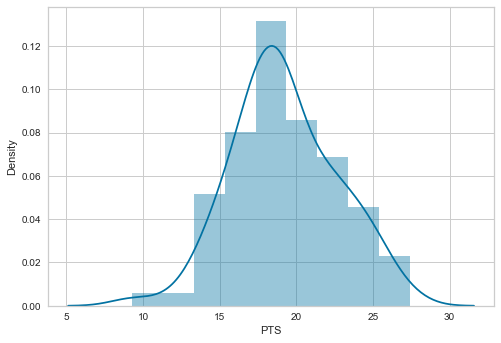

In [99]:
# Realizamos una prueba de EDA con el cluster 3
# sns.distplot(df_medicalCost.loc[df_medicalCost.bmi > 30, 'charges'], ax=ax)
# sns.lmplot(x="bmi", y="charges", hue="smoker", data=df_medicalCost, palette = 'magma', size = 6, aspect=2)
sb.distplot(df_00.PTS[df_00.Cluster_pca3 == 3],)

In [100]:
# Media en Puntos del cluster 3
print(df_00.PTS[df_00.Cluster_pca3 == 3].mean())
print(df_00.PTS[df_00.Cluster_pca3 == 3].mean() * 1.20) # Puntuación un 20% más de la media del cluster

19.233333333333334
23.080000000000002


In [102]:
# Jugadores de este cluster con las puntuaciones más altas x 100 posesiones
df_00.PLAYER_NAME[(df_00.Cluster_pca3 == 3) & (df_00.PTS >= 25)]

46           Brook Lopez
238         John Collins
302    LaMarcus Aldridge
371       Nikola Vucevic
374           Obi Toppin
Name: PLAYER_NAME, dtype: object

In [103]:
# Jugadores del cluster 3, con un 20% más de puntos que la media del cluster..LOS GOAT DEL CLUSTER
df_00.loc[(df_00.Cluster_pca3 == 3) & (df_00.PTS >= df_00.PTS[df_00.Cluster_pca3 == 3].mean() * 1.20), \
          ["PLAYER_NAME","PTS"]].sort_values(by="PTS", ascending=False)

,PLAYER_NAME,PTS
302,LaMarcus Aldridge,27.4
374,Obi Toppin,26.0
371,Nikola Vucevic,25.8
238,John Collins,25.6
46,Brook Lopez,25.2
32,Bobby Portis,24.4
208,Jalen Smith,24.4
362,Naz Reid,24.4
470,Trey Lyles,24.3
486,Wendell Carter Jr.,24.0


In [104]:
# Jugadores del cluster 0, con un 20% más de puntos que la media del cluster..LOS GOAT DEL CLUSTER
df_00.loc[(df_00.Cluster_pca3 == 0) & (df_00.PTS >= df_00.PTS[df_00.Cluster_pca3 == 0].mean() * 1.20), \
          ["PLAYER_NAME","PTS"]].sort_values(by="PTS", ascending=False)

,PLAYER_NAME,PTS
366,Nic Claxton,20.2
62,Charles Bassey,19.8
480,Udoka Azubuike,19.6
72,Clint Capela,19.3
377,Onyeka Okongwu,19.2
367,Nick Richards,19.1
390,Paul Reed,18.6
172,Greg Monroe,18.2


In [106]:
# Jugadores del cluster 4, con un 20% más de puntos que la media del cluster..LOS GOAT DEL CLUSTER
df_00.loc[(df_00.Cluster_pca3 == 4) & (df_00.PTS >= df_00.PTS[df_00.Cluster_pca3 == 4].mean() * 1.20), \
          ["PLAYER_NAME","PTS"]].sort_values(by="PTS", ascending=False)

,PLAYER_NAME,PTS
237,Joel Embiid,44.8
164,Giannis Antetokounmpo,42.2
318,Luka Doncic,40.1


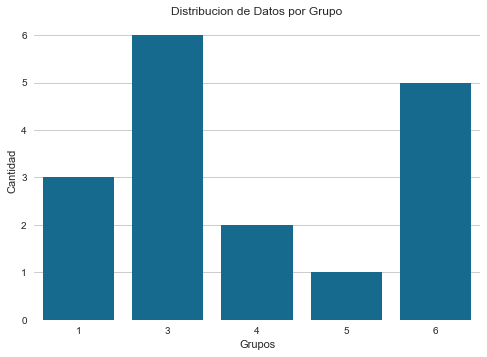

In [107]:
# Scouting de un equipo en funcion de la clusterización de jugadores
sb.countplot(df_00.Cluster_pca3[df_00.TEAM_ABBREVIATION == "DEN"], color = 'b'  )
plt.title('Distribucion de Datos por Grupo')
plt.xlabel('Grupos')
plt.ylabel('Cantidad')
sb.despine(left=True, bottom=True)

In [108]:
df_00.Cluster_pca3[df_00.TEAM_ABBREVIATION == "DEN"].value_counts()

3    6
6    5
1    3
4    2
5    1
Name: Cluster_pca3, dtype: int64

In [123]:
df_00[df_00.TEAM_ABBREVIATION == "DEN"].groupby(by="Cluster_pca3")["PLAYER_NAME"].count()

Cluster_pca3
1    3
3    6
4    2
5    1
6    5
Name: PLAYER_NAME, dtype: int64

In [109]:
# Medias de los clusters pca3
df_00[df_00.TEAM_ABBREVIATION == "DEN"].groupby(by="Cluster_pca3").mean().iloc[:,8:29]

,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,FT_PCT,OREB,DREB,REB,AST,TOV,STL,BLK,BLKA,PF,PFD,PTS,PLUS_MINUS
Cluster_pca3,,,,,,,,,,,,,,,,,,,,,
1,5.266667,12.366667,0.4280,2.466667,6.866667,0.361667,1.066667,1.433333,0.721000,1.200000,5.633333,6.80,3.633333,1.600000,1.666667,0.600000,0.466667,4.433333,1.700000,14.033333,-4.333333
3,6.900000,14.316667,0.4900,1.700000,5.483333,0.347833,3.316667,4.433333,0.745167,3.533333,6.750000,10.25,2.983333,2.583333,1.033333,0.933333,1.066667,5.366667,3.866667,18.833333,1.833333
4,12.400000,23.500000,0.5215,2.200000,6.850000,0.320000,6.850000,8.700000,0.785000,4.450000,14.400000,18.85,8.050000,5.550000,2.200000,1.300000,1.500000,6.450000,9.150000,33.750000,5.550000
5,4.400000,12.100000,0.3610,2.400000,7.900000,0.301000,2.400000,3.200000,0.769000,0.900000,3.800000,4.80,9.000000,2.700000,2.600000,0.900000,0.400000,5.100000,4.500000,13.500000,-8.600000
6,8.720000,20.620000,0.4280,4.540000,11.660000,0.388000,3.180000,3.680000,0.861200,0.580000,4.520000,5.12,4.920000,2.300000,1.440000,0.380000,1.320000,3.600000,2.940000,25.140000,1.500000
